# DALL·E mini - Inference pipeline

*Generate images from a text prompt*

<img src="https://github.com/borisdayma/dalle-mini/blob/main/img/logo.png?raw=true" width="200">

This notebook illustrates [DALL·E mini](https://github.com/borisdayma/dalle-mini) inference pipeline.

Just want to play? Use directly [the app](https://www.craiyon.com/).

For more understanding of the model, refer to [the report](https://wandb.ai/dalle-mini/dalle-mini/reports/DALL-E-mini--Vmlldzo4NjIxODA).

## 🛠️ Installation and set-up

In [ ]:
# Install required libraries
!pip install -q dalle-mini
!pip install -q git+https://github.com/patil-suraj/vqgan-jax.git

     |████████████████████████████████| 235 kB 8.7 MB/s 
     |████████████████████████████████| 197 kB 58.0 MB/s 
     |████████████████████████████████| 4.7 MB 37.3 MB/s 
     |████████████████████████████████| 1.8 MB 56.4 MB/s 
     |████████████████████████████████| 180 kB 65.3 MB/s 
     |████████████████████████████████| 53 kB 1.7 MB/s 
     |████████████████████████████████| 145 kB 60.1 MB/s 
     |████████████████████████████████| 1.1 MB 58.7 MB/s 
     |████████████████████████████████| 217 kB 51.2 MB/s 
     |████████████████████████████████| 51 kB 6.5 MB/s 
     |████████████████████████████████| 76 kB 6.0 MB/s 
     |████████████████████████████████| 120 kB 45.7 MB/s 
     |████████████████████████████████| 6.6 MB 32.3 MB/s 
     |████████████████████████████████| 181 kB 55.5 MB/s 
     |████████████████████████████████| 157 kB 50.7 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
     |████████████████████████████████| 157 kB 48.7 MB/s 
     |█████████████████

We load required models:
* DALL·E mini for text to encoded images
* VQGAN for decoding images
* CLIP for scoring predictions

In [ ]:
# Model references

# dalle-mega
DALLE_MODEL = "dalle-mini/dalle-mini/mega-1-fp16:latest"  # can be wandb artifact or 🤗 Hub or local folder or google bucket
DALLE_COMMIT_ID = None

# if the notebook crashes too often you can use dalle-mini instead by uncommenting below line
# DALLE_MODEL = "dalle-mini/dalle-mini/mini-1:v0"

# VQGAN model
VQGAN_REPO = "dalle-mini/vqgan_imagenet_f16_16384"
VQGAN_COMMIT_ID = "e93a26e7707683d349bf5d5c41c5b0ef69b677a9"

In [ ]:
import jax
import jax.numpy as jnp

# check how many devices are available
jax.local_device_count()

1

In [ ]:
# Load models & tokenizer
from dalle_mini import DalleBart, DalleBartProcessor
from vqgan_jax.modeling_flax_vqgan import VQModel
from transformers import CLIPProcessor, FlaxCLIPModel

# Load dalle-mini
model, params = DalleBart.from_pretrained(
    DALLE_MODEL, revision=DALLE_COMMIT_ID, dtype=jnp.float16, _do_init=False
)

# Load VQGAN
vqgan, vqgan_params = VQModel.from_pretrained(
    VQGAN_REPO, revision=VQGAN_COMMIT_ID, _do_init=False
)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Downloading large artifact mega-1-fp16:latest, 4938.53MB. 7 files... Done. 0:0:50.1
Some of the weights of DalleBart were initialized in float16 precision from the model checkpoint at /tmp/tmp_fwx1kyt:
[('lm_head', 'kernel'), ('model', 'decoder', 'embed_positions', 'embedding'), ('model', 'decoder', 'embed_tokens', 'embedding'), ('model', 'decoder', 'final_ln', 'bias'), ('model', 'decoder', 'layernorm_embedding', 'bias'), ('model', 'decoder', 'layernorm_embedding', 'scale'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'k_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'out_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'q_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBartDecoderLayers', 'FlaxBartAttention_0', 'v_proj', 'kernel'), ('model', 'decoder', 'layers', 'FlaxBart

Model parameters are replicated on each device for faster inference.

In [ ]:
from flax.jax_utils import replicate

params = replicate(params)
vqgan_params = replicate(vqgan_params)

Model functions are compiled and parallelized to take advantage of multiple devices.

In [ ]:
from functools import partial

# model inference
@partial(jax.pmap, axis_name="batch", static_broadcasted_argnums=(3, 4, 5, 6))
def p_generate(
    tokenized_prompt, key, params, top_k, top_p, temperature, condition_scale
):
    return model.generate(
        **tokenized_prompt,
        prng_key=key,
        params=params,
        top_k=top_k,
        top_p=top_p,
        temperature=temperature,
        condition_scale=condition_scale,
    )


# decode image
@partial(jax.pmap, axis_name="batch")
def p_decode(indices, params):
    return vqgan.decode_code(indices, params=params)

Keys are passed to the model on each device to generate unique inference per device.

In [ ]:
import random

# create a random key
seed = random.randint(0, 2**32 - 1)
key = jax.random.PRNGKey(seed)

## 🖍 Text Prompt using Facebook BART summarizer

Our model requires processing prompts.

In [ ]:
from dalle_mini import DalleBartProcessor

processor = DalleBartProcessor.from_pretrained(DALLE_MODEL, revision=DALLE_COMMIT_ID)

wandb: Downloading large artifact mega-1-fp16:latest, 4938.53MB. 7 files... Done. 0:0:41.7


Downloading:   0%|          | 0.00/34.2M [00:00<?, ?B/s]

In [ ]:
#installing the transformers library
%pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import pipeline

In [ ]:
prompts= [r'The Amazon rainforest, the largest rainforest on Earth, encompasses an area roughly the size of the United States (the 48 contiguous states), contains most of the plant and animal species found on the planet and contributes to weather patterns on a global scale. This natural wonder is disappearing at an alarming rate due to deforestation and with it the animals, plants and eventually humans will disappear as well. This applies to all plants, animals and humans, not just those who inhabit this region of South America. If the Amazon rainforest disappears, the entire human race will likely suffer the same fate resulting from the climatic changes that would result. This disturbing scenario has been well documented by environmental organizations, governmental studies, independent agency reviews and scientific journals spanning the past three decades from which this discussion will draw. The Amazon rainforest represents close to half of the world’s rainforest regions. Estimates of its size vary but the general consensus is that the Amazon rainforest covers approximately seven million square kilometers. It represents 40 per cent of the South American continent encroaching on nine of its countries including Brazil, Suriname, Bolivia, Guyana, French Guyana, Ecuador, Peru, Colombia and Venezuela. The greatest portion (62 per cent) lies within the boundaries of Brazil. This massive area, if a single country, would rank sixth largest in the world and is at least half the size of the entire European continent. The seemingly boundless rainforest is shrinking at a rapid pace due to deforestation, however, which will soon result in grave consequences for both the region and the planet. Deforestation describes the removal of trees along with other types of vegetation. Since 1970, at least 20 per cent of Amazon rainforest has been lost from deforestation. This figure could be under-representative because it does not include trees that have been felled by selective logging techniques which are less noticeable than clear-cutting yet causes considerable harm. Ecologists and scientists warn that another 20 per cent will be lost within the next 20 years. If this were to occur, the ecological system that sustains the forest and thus the planet’s weather patterns will start to disintegrate. At present, the Amazon rainforest generates half of the rainfall it consumes but the removal of an additional 20 per cent will impede this phenomenon to the point where much of the remaining forest will die from lack of moisture. The rising temperature of the Earth, due to global warming, will exacerbate the situation and cause droughts which will lead to massive wildfires in the region. Instead of life-giving oxygen which is now furnished by the lush rainforests, the fires will expel great amounts of carbon dioxide into the atmosphere. Given this very real and impending scenario, it is difficult to imagine how the human race along with all other life on earth could continue to live. Today, the greenhouse gases emitted from Brazil ranks near the world’s top polluter, the U.S., because of the slash-and-burn techniques used to clear the rainforest. Simply stated, if immediate action is not taken to reverse the present trend of deforestation, the immense Amazon rainforest will soon become a desert region not unlike the Sahara in Africa. Once this process is underway, the effects are irreversible. Some scientists believe the transformation from forest to desert could begin as early as this year. Studies have determined that the Amazon rainforest, even in its current state, could not withstand three years of drought conditions without beginning the irrevocable path to becoming the Amazon desert. This result, in and of itself, is tragic enough but the repercussions to the rest of the world would be as catastrophic. It is astonishing that though people know that without trees, they are without oxygen, the trees keep falling at increasingly larger rates. Trees are a resource that can be replenished if cutting is managed properly yet this has been anything but the case in the Amazon. The collective rainforests of the world act as a climatic sponge storing much of the world’s rainwater, of which the Amazon rainforest accounts for more than half. Trees in the rainforest recycle water drawn from the forest ground. This, combined with the moisture that evaporates from the leaves is released into the atmosphere from whence it came. If not for this enormous amount of rainwater supplied by rainforests, rivers, lakes and land masses would essentially dry-up spawning droughts of epic proportions. Irrigation farming would be greatly curtailed. Disease, starvation and famine on a worldwide scale will be the direct result of deforestation. Trees cleanse the atmosphere by absorbing carbon dioxide and providing oxygen. Burning trees in the rainforest increases the amount of carbon in the atmosphere and at the same time reduces the amount of trees needed to absorb it. This contributes to global warming, a phenomenon which is already threatening the survival of the planet. There are further, often less publicized, repercussions of the Amazon rainforest’s deforestation. As trees are removed from the rainforest, soil erosion becomes an increasing concern. The nutrients needed for the tree’s roots to thrive are contained in a rainforest soil that is surprisingly lacking in nutrients. The bulk of the nutrients are stored within the massive number of trees whose collective canopies protect the rainforest soil from the torrential downpours that would otherwise wash the soil away eventually allowing the rivers to flood low lying areas. The mass clearing of trees is the obvious threat to soil erosion but selective cutting is too. The soil does need some nutrients in order to hold the tree’s roots firmly which it gains when trees die and decay on the ground. Fewer numbers of trees to feed the soil will lead to lower quality soil thus fewer trees still, a process that is essentially irreversible. The rain forest is also home to indigenous tribes, many who have become extinct in the past three decades. Some have estimated that more than 100 entire tribes have been lost in recent years. After living harmoniously with nature for untold thousands of years, deforestation has deprived these indigenous peoples of the land which provided them housing, food and medications. Many were killed by the diseases brought in by the loggers or outright while attempting to protect their homes. Medicines that originate from rainforest plants are not only important to the indigenous tribes but to the rest of the world population as well. More than a quarter of contemporary medications were derived from rainforest plants but only one percent of these plants have been tapped for their medicinal value. Therefore, the potential for life-saving medicines yet discovered is tremendous. Loggers do not wish for the rainforests to vanish, if for no other reason, because their livelihoods depends on it. They claim the world would have to stop using wood for the demand to diminish. The demand, not the supply is destroying the rainforest. In addition, if this unlikely scenario were to happen, commercial ranchers, tribesmen and miners would continue to clear trees at an enormous rate. The ever-expansive soybean farms and wealth of precious metals in the region assure the continued deforestation with or without the presence of loggers. The various South American governments’ position is similar to the loggers in that they do not wish the rainforest to be destroyed because of the financial hardship it would cause. This stance is eerily similar to the U.S. position on global warming, that to tackle the problem would not be economically feasible. Both seem to be quite content to sacrifice the future of the planet’s inhabitants for short-term political or economic gains. Environmentalists cite previously mentioned catastrophic global concerns and the tribes’ people lament the destruction of their beautiful and exotic homeland. The proliferation of soy bean farming has negatively impacted the Amazon rainforest. The soy farmers hold much influence in South American countries’ governments. Beyond the massive clearing of trees to provide more farmland, the soy farmers continually persuade government officials to expand roadways which allow more of those with both legitimate and illegal commercial concerns access to increasing larger amounts of rainforest areas. As in logging, the blame can largely be pointed at the demand-side. Environment Secretary David Miliband proposed offering sections of the Amazon rainforest to be sold to private individuals, associations and businesses for strictly preservation purposes. This would compensate the governments and stop the deforestation, at least in those regions. The Brazilian government quickly dismissed the proposal citing the possible undermining of its autonomy. Brazil is implementing a monitoring scheme to track illegal logging which it contends will slow the destruction of forests. However, this can only be a temporary solution because partially cleared forests are no substitute for untouched forests, ecologically speaking. Local governments of the Amazon region have been less than helpful in curbing the destruction of the rainforests. In fact, not only has few, if any, resolutions to the problem emanated from local authorities, many have actively thwarted attempts to save it. Local authorities often act in conjunction with drug cartels (gangs) and ranchers who profit from the clearing of rainforests. Because of the impoverished conditions which rampant throughout the region, corruption also runs rampant. The governments of the region cannot be counted on to improve conditions now or in the future. The only viable method of preserving the rainforests is to appeal to the economic realities of the region. More prosperous countries should, one, stop buying from companies that exploit the rainforest’s resources and two, employ Miliband’s privatization plan. Saving the Amazon rainforest is a good idea whether or not its destruction would also likely kill most everything on earth. Even if all the scientists, environmentalists, government and scholarly studies were proved 100 percent wrong and nothing outside a few desolate tribes, some frogs, snakes and birds would notice if the rainforest was transformed into desert, it would still be worth saving at any cost due to its beauty, uniqueness and numbers of species and medicinal potential. Much as the global warming issue, whose destiny is tied to deforestation, even if climate change due to carbon monoxide emissions were proved a myth, reducing air pollution still makes sense.']

In [ ]:
#prompts = [r'African wild dog, (Lycaon pictus), also called Cape hunting dog, African hunting dog, or hyena dog, wild African carnivore that differs from the rest of the members of the dog family (Canidae) in having only four toes on each foot. Its coat is short, sparse, and irregularly blotched with yellow, black, and white. The African wild dog is about 76–102 cm (30–41 inches) long, exclusive of its 31–41-cm tail, stands about 60 cm (24 inches) tall at the shoulder, and weighs about 16–23 kg (35–50 pounds).The African wild dog is long-limbed with a broad flat head, a short muzzle, and large erect ears. It hunts in packs of 15 to 60 or more and is found in parts of Africa south and east of the Sahara, particularly in grasslands. It usually preys on antelopes and some larger game but has been hunted in settled regions for the damage it sometimes does to domestic livestock. The average number of young per litter appears to be about six; gestation periods of about 60 and 80 days have been noted.']


In [ ]:
prompts = [r"Elephants are the largest land mammals on earth and have distinctly massive bodies, large ears, and long trunks. They use their trunks to pick up objects, trumpet warnings, greet other elephants, or suck up water for drinking or bathing, among other uses. Both male and female African elephants grow tusks and each individual can either be left- or right-tusked, and the one they use more is usually smaller because of wear and tear. Elephant tusks serve many purposes. These extended teeth can be used to protect the elephant's trunk, lift and move objects, gather food, and strip bark from trees. They can also be used for defense. During times of drought, elephants even use their tusks to dig holes to find water underground. Two genetically different African species exist: the savanna elephant and the forest elephant, with a number of characteristics that differentiate them both. The African savanna elephant is the largest elephant species, while the Asian forest elephant and the African forest elephant are of a comparable, smaller size. Asian elephants differ in several ways from their African relatives, with more than 10 distinct physical differences between them. For example, Asian elephants' ears are smaller compared to the large fan-shaped ears of the African species. Only some male Asian elephants have tusks, while both male and female African elephants grow tusks. Led by a matriarch, elephants are organized into complex social structures of females and calves, while male elephants tend to live in isolation or in small bachelor groups. A single calf is born to a female once every four to five years and after a gestation period of 22 months—the longest of any mammal. Calves are cared for by the entire herd of related females. Female calves may stay with their maternal herd for the rest of their lives, while males leave the herd as they reach puberty. Forest elephants' social groups differ slightly and may be comprised of only an adult female and her offspring. However, they may congregate in larger groups in forest clearings where resources are more abundant. Elephants need extensive land areas to survive and meet their ecological needs, which includes food, water, and space. On average, an elephant can feed up to 18 hours and consume hundreds of pounds of plant matter in a single day. As a result, as they lose habitat, they often come into conflict with people in competition for resources."]

Let's define some text prompts.

In [ ]:
#prompts = [
 #   "sunset over a lake in the mountains",
  #  "the Eiffel tower landing on the moon",
#]

In [ ]:
len(prompts[0].split())

401

Note: we could use the same prompt multiple times for faster inference.

In [ ]:
tokenized_prompts = processor(prompts)

Finally we replicate the prompts onto each device.

In [ ]:
tokenized_prompt = replicate(tokenized_prompts)

## 🎨 Generate images

We generate images using dalle-mini model and decode them with the VQGAN.

In [ ]:

# number of predictions per prompt
n_predictions = 16

# We can customize generation parameters (see https://huggingface.co/blog/how-to-generate)
gen_top_k = None
gen_top_p = None
temperature = None
cond_scale = 10.0

Prompts: ["Elephants are the largest land mammals on earth and have distinctly massive bodies, large ears, and long trunks. They use their trunks to pick up objects, trumpet warnings, greet other elephants, or suck up water for drinking or bathing, among other uses. Both male and female African elephants grow tusks and each individual can either be left- or right-tusked, and the one they use more is usually smaller because of wear and tear. Elephant tusks serve many purposes. These extended teeth can be used to protect the elephant's trunk, lift and move objects, gather food, and strip bark from trees. They can also be used for defense. During times of drought, elephants even use their tusks to dig holes to find water underground. Two genetically different African species exist: the savanna elephant and the forest elephant, with a number of characteristics that differentiate them both. The African savanna elephant is the largest elephant species, while the Asian forest elephant and the

  0%|          | 0/16 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/jax/_src/ops/scatter.py:90: FutureWarning: scatter inputs have incompatible types: cannot safely cast value from dtype=float16 to dtype=float32. In future JAX releases this will result in an error.
  FutureWarning)


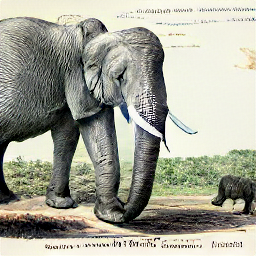

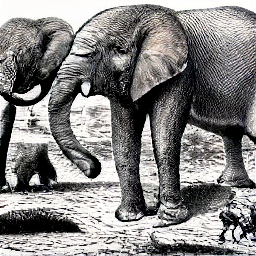

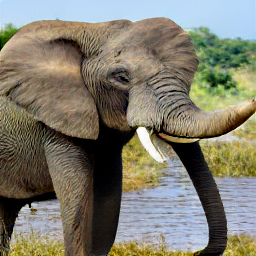

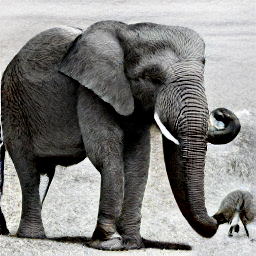

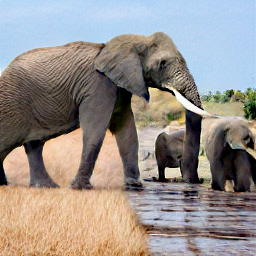

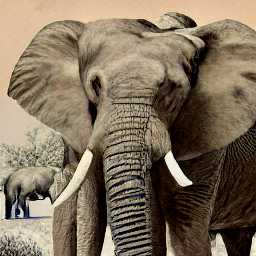

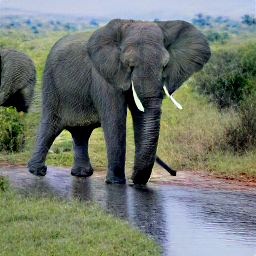

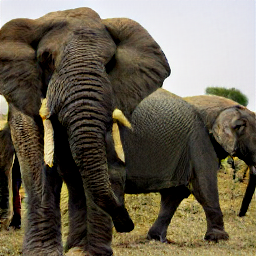

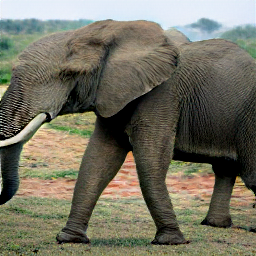

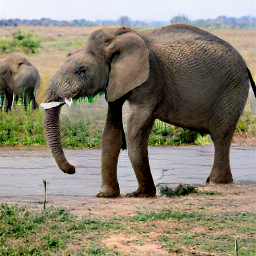

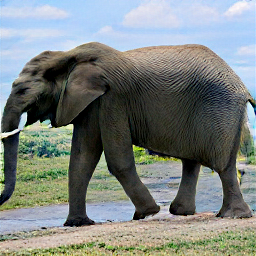

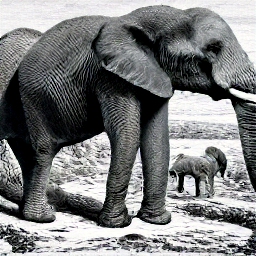

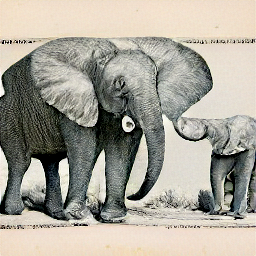

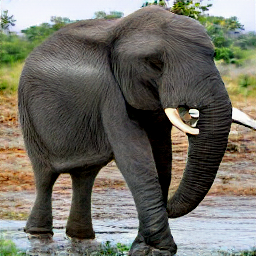

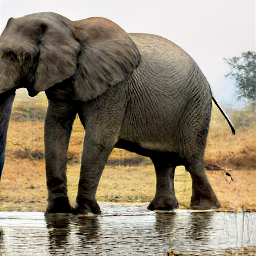

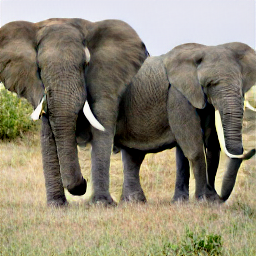

In [ ]:
from flax.training.common_utils import shard_prng_key
import numpy as np
from PIL import Image
from tqdm.notebook import trange
import time

start = time.time()
print(f"Prompts: {prompts}\n")
# generate images
images = []
for i in trange(max(n_predictions // jax.device_count(), 1)):
    # get a new key
    key, subkey = jax.random.split(key)
    # generate images
    encoded_images = p_generate(
        tokenized_prompt,
        shard_prng_key(subkey),
        params,
        gen_top_k,
        gen_top_p,
        temperature,
        cond_scale,
    )
    # remove BOS
    encoded_images = encoded_images.sequences[..., 1:]
    # decode images
    decoded_images = p_decode(encoded_images, vqgan_params)
    decoded_images = decoded_images.clip(0.0, 1.0).reshape((-1, 256, 256, 3))
    for decoded_img in decoded_images:
        img = Image.fromarray(np.asarray(decoded_img * 255, dtype=np.uint8))
        images.append(img)
        display(img)
        print()
end = time.time()

In [ ]:
print('time taken to run',end-start)

time taken to run 224.2709300518036


## 🏅 Optional: Rank images by CLIP score

We can rank images according to CLIP.

**Note: your session may crash if you don't have a subscription to Colab Pro.**

In [ ]:
# CLIP model
CLIP_REPO = "openai/clip-vit-base-patch32"
CLIP_COMMIT_ID = None

# Load CLIP
clip, clip_params = FlaxCLIPModel.from_pretrained(
    CLIP_REPO, revision=CLIP_COMMIT_ID, dtype=jnp.float16, _do_init=False
)
clip_processor = CLIPProcessor.from_pretrained(CLIP_REPO, revision=CLIP_COMMIT_ID)
clip_params = replicate(clip_params)

# score images
@partial(jax.pmap, axis_name="batch")
def p_clip(inputs, params):
    logits = clip(params=params, **inputs).logits_per_image
    return logits

In [ ]:
from flax.training.common_utils import shard

# get clip scores
clip_inputs = clip_processor(
    text=prompts * jax.device_count(),
    images=images,
    return_tensors="np",
    padding="max_length",
    max_length=77,
    truncation=True,
).data
logits = p_clip(shard(clip_inputs), clip_params)

# organize scores per prompt
p = len(prompts)
logits = np.asarray([logits[:, i::p, i] for i in range(p)]).squeeze()

Let's now display images ranked by CLIP score.

Prompt: Elephants are the largest land mammals on earth and have distinctly massive bodies, large ears, and long trunks. They use their trunks to pick up objects, trumpet warnings, greet other elephants, or suck up water for drinking or bathing, among other uses. Both male and female African elephants grow tusks and each individual can either be left- or right-tusked, and the one they use more is usually smaller because of wear and tear. Elephant tusks serve many purposes. These extended teeth can be used to protect the elephant's trunk, lift and move objects, gather food, and strip bark from trees. They can also be used for defense. During times of drought, elephants even use their tusks to dig holes to find water underground. Two genetically different African species exist: the savanna elephant and the forest elephant, with a number of characteristics that differentiate them both. The African savanna elephant is the largest elephant species, while the Asian forest elephant and the Af

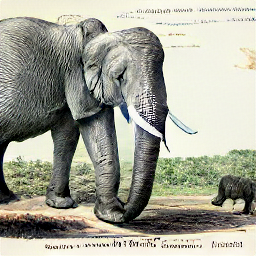

IndexError: ignored

In [ ]:
for i, prompt in enumerate(prompts):
    print(f"Prompt: {prompt}\n")
    for idx in logits[i].argsort()[::-1]:
        display(images[idx * p + i])
        print(f"Score: {jnp.asarray(logits[i][idx], dtype=jnp.float32):.2f}\n")
    print()

## 🪄 Optional: Save your Generated Images as W&B Tables

W&B Tables is an interactive 2D grid with support to rich media logging. Use this to save the generated images on W&B dashboard and share with the world.

In [ ]:
import wandb

# Initialize a W&B run.
project = 'dalle-mini-tables-colab'
run = wandb.init(project=project)

# Initialize an empty W&B Tables.
columns = ["captions"] + [f"image_{i+1}" for i in range(n_predictions)]
gen_table = wandb.Table(columns=columns)

# Add data to the table.
for i, prompt in enumerate(prompts):
    # If CLIP scores exist, sort the Images
    if logits is not None:
        idxs = logits[i].argsort()[::-1]
        tmp_imgs = images[i::len(prompts)]
        tmp_imgs = [tmp_imgs[idx] for idx in idxs]
    else:
        tmp_imgs = images[i::len(prompts)]

    # Add the data to the table.
    gen_table.add_data(prompt, *[wandb.Image(img) for img in tmp_imgs])

# Log the Table to W&B dashboard.
wandb.log({"Generated Images": gen_table})

# Close the W&B run.
run.finish()

Click on the link above to check out your generated images.